In [121]:
import configparser
# import sembed_text_cohere as emb
from scipy.cluster.hierarchy import linkage, dendrogram # , fcluster, to_tree
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import importlib
import src.dimensionality_reduction as dr
importlib.reload(dr)
import colorsys

from datasets import load_dataset
import cohere
import pandas as pd

from vedo import Points, Line, show, Group, Lines, vector, Box, Assembly

## Load in wikipedia dataset

In [22]:
reduced_npz = np.load('./demo_data/combined_reduced_embeddings.npz', allow_pickle=True)
embedding_npz = np.load('./demo_data/combined_embeddings.npz', allow_pickle=True)

filenames = embedding_npz['filenames']
embeddings = embedding_npz['embeddings']
umap2 = reduced_npz['umap2']
pca5 = reduced_npz['pca5']

In [27]:
response = input("Are you sure you want to generate the embeddings again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    config = configparser.ConfigParser()
    config.read("./config.ini")
    api_key = config.get('cohere', 'api_key')

    # Add your cohere API key from www.cohere.com
    co = cohere.Client(api_key)  

    #Load at max 2000 documents + embeddings
    max_docs = 2000
    docs_stream = load_dataset(f"Cohere/wikipedia-22-12-simple-embeddings", split="train", streaming=True)

    docs = []

    for doc in docs_stream:
        docs.append(doc)
        # titles.append(doc['title'])
        # text.append(doc['text'])
        # doc_embeddings.append(doc['emb'])
        if len(docs) >= max_docs:
            break

    df = pd.DataFrame(docs)
    embeddings = np.array(df['emb'].tolist())
    filenames = np.array(df['title'].tolist())
    # stores df as npz file in demo_data folder
    np.savez('./demo_data/wiki2000_embeddings_filenames.npz', embeddings=embeddings, filenames=filenames)

In [28]:
# loads df from npz file
wiki_embeddings = np.load('./demo_data/wiki2000_embeddings_filenames.npz', allow_pickle=True)
filenames = wiki_embeddings['filenames']
embeddings = wiki_embeddings['embeddings']

array([[ 0.07711288,  0.31971741, -0.20515901, ..., -0.26713574,
         0.0303479 ,  0.05174244],
       [ 0.1961289 ,  0.51426697,  0.03864574, ..., -0.19372283,
         0.2940397 , -0.11770557],
       [ 0.1391919 ,  0.17759687, -0.11669647, ..., -0.25139177,
         0.33378783,  0.21392426],
       ...,
       [ 0.33850774,  0.04350469, -0.16285717, ..., -0.43892732,
         0.09958533, -0.11265448],
       [ 0.09053483,  0.026901  , -0.12703803, ..., -0.32155684,
         0.09108315, -0.1729067 ],
       [ 0.24693862,  0.12482832, -0.4790355 , ..., -0.56318676,
         0.27820253, -0.14000368]])

## Dimensionality reduction

In [29]:
response = input("Are you sure you want to generate the reductions again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    reduced_embeddings = dr.run_dimensionality_reduction(embeddings, ['pca5'])
    np.savez('./demo_data/wiki2000_reduced_embeddings.npz', **reduced_embeddings)

Running PCA 5


In [30]:
# loads reductions
reduced_npz = np.load('./demo_data/wiki2000_reduced_embeddings.npz', allow_pickle=True)
# umap2 = reduced_npz['umap2']
pca5 = reduced_npz['pca5']

## Dendrogram

### Helper functions

In [125]:
# Adds colors for linkages by blending the leave colors together, recursively
# if t is 1, color2 is returned, if it is 0, color1 is
def blend_colors(color1, color2, weight):
    # Convert RGB colors to HSV
    hsv1 = colorsys.rgb_to_hsv(*color1)
    hsv2 = colorsys.rgb_to_hsv(*color2)

    # Blend the colors based on the weight
    blended_hsv = (
        (1 - weight) * hsv1[0] + weight * hsv2[0],    # Weighted average of the hues
        (1 - weight) * hsv1[1] + weight * hsv2[1],    # Weighted average of the saturations
        (1 - weight) * hsv1[2] + weight * hsv2[2]     # Weighted average of the values/brightness
    )

    # Convert the blended color back to RGB
    blended_rgb = colorsys.hsv_to_rgb(*blended_hsv)

    return blended_rgb

# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
#  Creates value of links, such as color, by blending together leaf values
def create_link_values(linkage_matrix, leaf_values,
                      merge_function = lambda cluster1_val, cluster2_val, weight: cluster1_val * (1 - weight) + cluster2_val * weight,
                      weight_function = lambda cluster1_size, cluster2_size: cluster2_size / (cluster1_size + cluster2_size)):
    # Merge function takes val1, val2, and a weight (0-1, 0 preferences val1, 1 preferences val2) and returns a merged value

    num_leaves = len(leaf_values)
    
    new_values = leaf_values.copy()
    for row in linkage_matrix:
        cluster1_id = int(row[0])
        cluster2_id = int(row[1])

        if cluster1_id < num_leaves: # it is a sample/leaaf
            cluster1_size = 1
        else:
            cluster1_size = linkage_matrix[num_leaves - cluster1_id][-1]
        
        if cluster2_id < num_leaves: # it is a sample/leaf
            cluster2_size = 1
        else:
            cluster2_size = linkage_matrix[num_leaves - cluster2_id][-1]

        # If a cluster is huge and is merged with a leaf, the weight should preference the cluster
        # Can try different weighting here
        weight = weight_function(cluster1_size, cluster2_size)

        merged_cluster_value = np.array([merge_function(new_values[cluster1_id], new_values[cluster2_id], weight)])

        new_values = np.concatenate((new_values, merged_cluster_value), axis=0)

    return new_values

/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


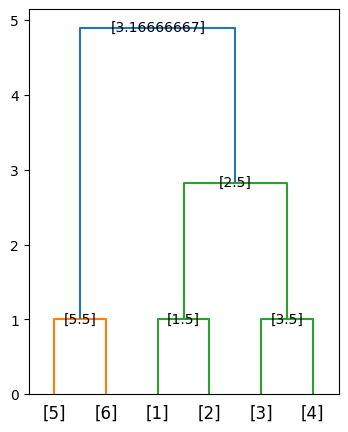

In [164]:
leaf_values = np.array([[1,2,3,4,5,6]]).T
# leaf_colors = np.array([[1,0,0], [0,1,0], [0,0,1], [0,0,1]])

# linkage_matrix = np.array([[0,1,1,2],    # link 1 avg = 4.5
#                            [2,3,1.5,3]]) # link 2 avg = 5.5
linkage_matrix = linkage(leaf_values, method='ward')


link_labels = create_link_values(linkage_matrix, leaf_values[ddata['leaves']])
# link_colors = create_link_values(linkage_matrix, leaf_colors, merge_function=blend_colors)
# # converts to matplotlib colors
# link_colors = [mcolors.to_hex(color) for color in link_colors]


plt.figure(figsize=(4, 5))

ddata = dendrogram(linkage_matrix, labels=leaf_values)#, link_color_func=lambda id: link_colors[id])

for icoord, dcoord, label in zip(ddata['icoord'], ddata['dcoord'], link_labels[len(leaf_values):]):
    x = 0.5 * sum(icoord[1:3])
    y = dcoord[1]
    plt.text(x, y, label, va='center', ha='center', size=10)


plt.show()

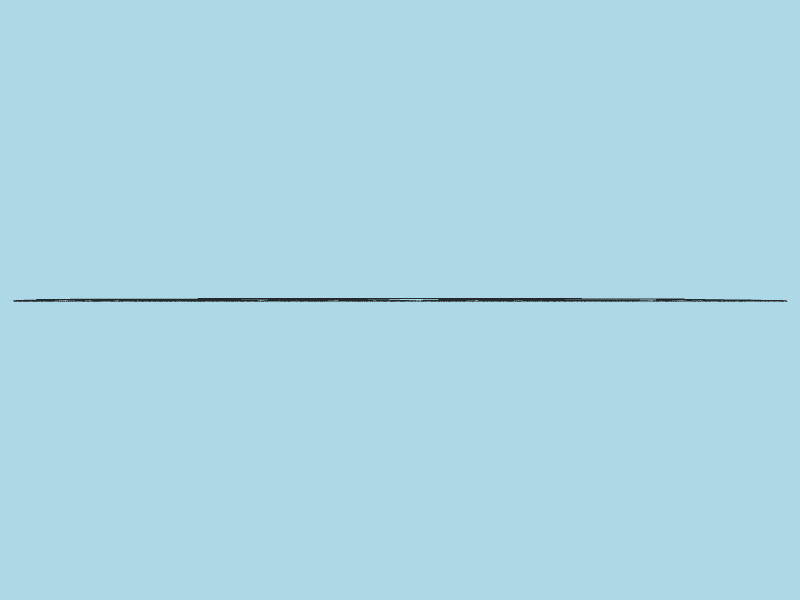

In [130]:
num_samples = len(filenames)

class ClusterLine(Line):
    def __init__(self, p1, p2, cluster_info):
        super().__init__(p1, p2)
        self.cluster_info = cluster_info

filenames = embedding_npz['filenames']

linked = linkage(embeddings, method='ward')
dendro = dendrogram(linked, no_plot=True)
#dendro = dendrogram(linked, truncate_mode='lastp')

edges = []
leaf_points_coords = []  # to store the leaf points
points_filenames = []  # to store filenames corresponding to the leaf points

# Loop over each set of coordinates and create lines
for i in range(len(dendro['icoord'])):
    x_coords = dendro['icoord'][i]
    y_coords = dendro['dcoord'][i]
   
    for j in range(1, len(x_coords)):
        start_point = [x_coords[j-1], y_coords[j-1], 0]
        end_point = [x_coords[j], y_coords[j], 0]
      
        cluster_info = linked[i]
        edges.append(ClusterLine(start_point, end_point, cluster_info))

    leaf_points_coords.append([x_coords[0], y_coords[0], 0])
    leaf_points_coords.append([x_coords[-1], y_coords[-1], 0])

# Create Points object for leaf nodes
#leaf_points = Points(leaf_points_coords, r=5, c="red5")

# Add filenames to leaf points
# for i in range(len(leaf_points_coords)):
#     points_filenames.append(filenames[i])


box_list = []

for point_coord in leaf_points_coords:
    
    leaf_box = Box(pos=point_coord,
	length=5.0,
	width=5.0,
	height=5.0,
	c='g4',
	alpha=1.0)

    box_list.append(leaf_box)


txt = "filename"
# caption_list = [box.caption(txt, size=(0.04,0.03), font="LogoType", c='tomato')
#                 for box in box_list]

show(edges, bg='lightblue')

In [131]:
ddata

{'icoord': [[15.0, 15.0, 25.0, 25.0], [5.0, 5.0, 20.0, 20.0]],
 'dcoord': [[0.0, 1.0, 1.0, 0.0], [0.0, 1.5, 1.5, 1.0]],
 'ivl': [2, 0, 1],
 'leaves': [2, 0, 1],
 'color_list': ['#ffff00', '#00ff00'],
 'leaves_color_list': ['#00ff00', '#ffff00', '#ffff00']}

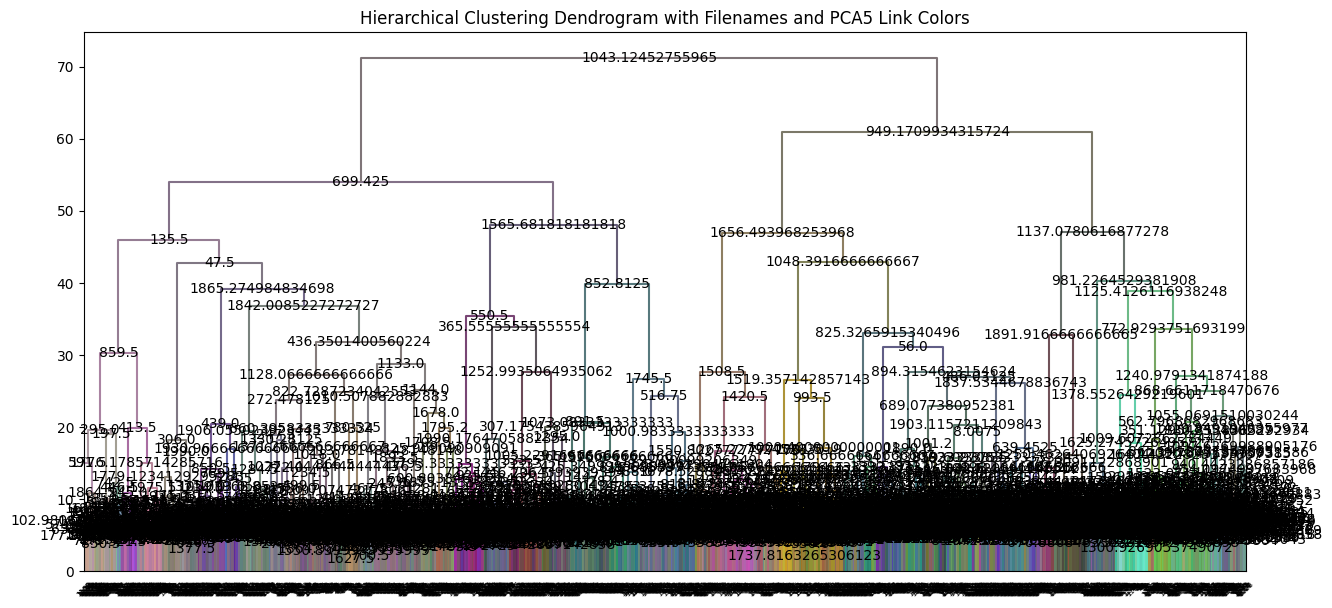

In [101]:
plt.figure(figsize=(15, 7))

# Perform hierarchical clustering using the 'ward' method
linkage_matrix = linkage(embeddings, method='ward')

colors = pca5[:, 2:5]
leaf_names = range(embeddings.shape[0])

link_leaf_colors = create_link_values(linkage_matrix, colors, merge_function=blend_colors)
link_leaf_colors = [mcolors.to_hex(color) for color in link_leaf_colors]

# Plot the dendrogram with custom labels and link colors
ddata = dendrogram(linkage_matrix, leaf_rotation=45, labels=leaf_names, link_color_func=lambda link_id: link_leaf_colors[link_id])

link_labels = create_link_values(linkage_matrix, np.array([i for i in range(embeddings.shape[0])]))[len(leaf_names):]

for icoord, dcoord, label in zip(ddata['icoord'], ddata['dcoord'], link_labels):
    x = 0.5 * sum(icoord[1:3])
    y = dcoord[1]
    plt.text(x, y, label, va='center', ha='center', size=10)


plt.title('Hierarchical Clustering Dendrogram with Filenames and PCA5 Link Colors')
plt.show()